In [1]:
from nest_model import create_model
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  6 2023 09:17:30

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
response = create_model()
response


Jun 03 18:24:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jun 03 18:24:04 NodeManager::prepare_nodes [Info]: 
    Preparing 806 nodes for simulation.

Jun 03 18:24:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 806
    Simulation time (ms): 2100
    Number of OpenMP threads: 1
    Not using MPI

Jun 03 18:24:04 SimulationManager::run [Info]: 
    Simulation finished.


{'events': [{'senders': array([  1,   2,   3, ..., 798, 799, 800]),
   'times': array([1.000e+00, 1.000e+00, 1.000e+00, ..., 2.099e+03, 2.099e+03,
          2.099e+03]),
   'V_m': array([ -70.        ,  -70.        ,  -70.        , ...,  -77.15903776,
           -70.70659668, -108.0780695 ])},
  {'senders': array([  4,  11,  15, ..., 273, 221, 140]),
   'times': array([   3.4,    4. ,    4. , ..., 2075.1, 2081.6, 2092. ])},
  {'senders': array([381, 312, 318, ..., 342, 786, 494]),
   'times': array([   3.5,    4.6,    4.4, ..., 2095.4, 2096.7, 2098.5])}]}

In [3]:
vm1 = response["events"][0]
sr1 = response["events"][1]
sr2 = response["events"][2]

spike_id_exc, spike_t_exc = sr1['senders'], sr1['times'] # from STN
spike_id_inh, spike_t_inh = sr2['senders'], sr2['times'] # from GPe
vm_id, vm_t = vm1['senders'], vm1['times']

### Raster plot

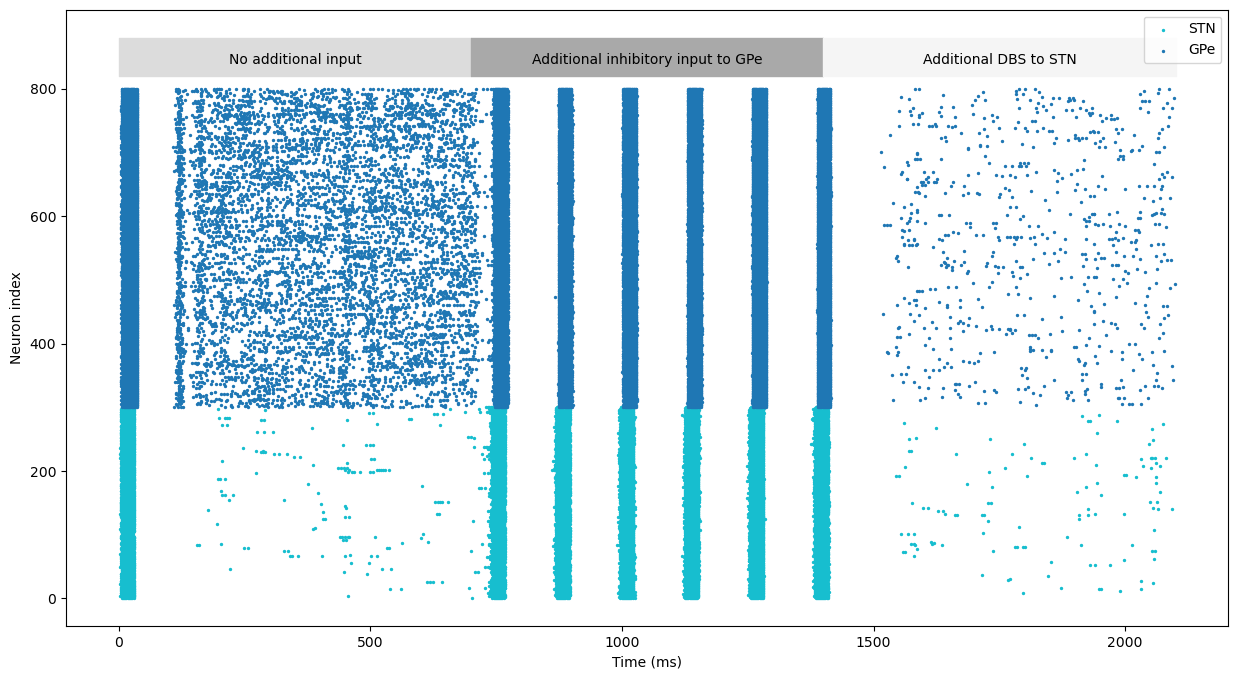

In [4]:
# Plot the spikes as a raster plot (time vs neuron index)

fig = plt.figure(figsize=(15, 8))

# plt.eventplot([spikes_exc, spikes_inh], colors=['tab:red', 'tab:blue'])
plt.scatter(spike_t_exc, spike_id_exc, color='tab:cyan', label='STN', s=2)
plt.scatter(spike_t_inh, spike_id_inh, color='tab:blue', label='GPe', s=2)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')

# add a top horizontal bar to indicate the stimulation periods 
plt.fill_between([0, 700], 820, 880, color='gainsboro')
plt.fill_between([700, 1400], 820, 880, color='darkgray')
plt.fill_between([1400, 2100], 820, 880, color='whitesmoke')

# add text to indicate the stimulation periods
plt.text(350, 845, 'No additional input', horizontalalignment='center', verticalalignment='center')
plt.text(1050, 845, 'Additional inhibitory input to GPe', horizontalalignment='center', verticalalignment='center')
plt.text(1750, 845, 'Additional DBS to STN', horizontalalignment='center', verticalalignment='center')

plt.legend()

# save the figure
fig.savefig('figs/raster_plot.png', dpi=300)

### Mean firing rate

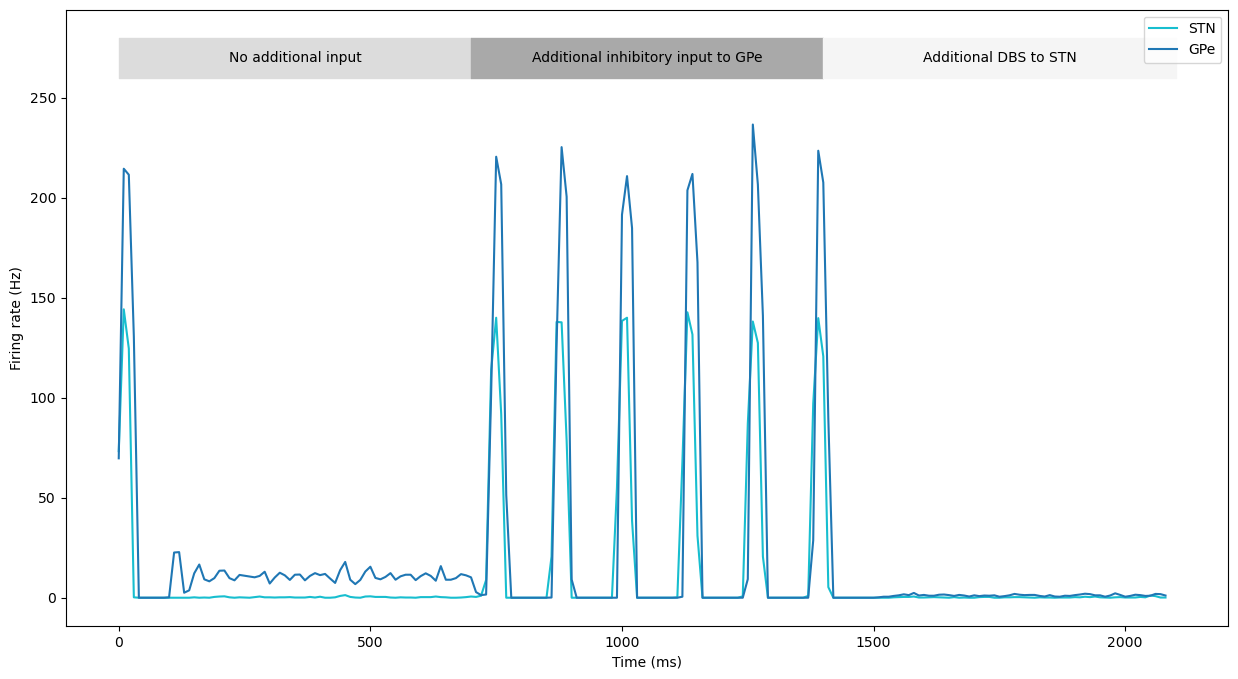

In [5]:

fig = plt.figure(figsize=(15, 8))

sr = 100
bin_size = 1000/sr
bins = np.arange(0,2100, bin_size)
counts_exc, bins_exc = np.histogram(spike_t_exc, bins=bins)
counts_inh, bins_inh = np.histogram(spike_t_inh, bins=bins)

fr_exc = counts_exc / bin_size
fr_inh = counts_inh / bin_size

plt.plot(bins[:-1], fr_exc , color='tab:cyan', label='STN')
plt.plot(bins[:-1], fr_inh, color='tab:blue', label='GPe')

plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')

# add a top horizontal bar to indicate the stimulation periods 
plt.fill_between([0, 700], 260, 280, color='gainsboro')
plt.fill_between([700, 1400], 260, 280, color='darkgray')
plt.fill_between([1400, 2100], 260, 280, color='whitesmoke')

# add text to indicate the stimulation periods
plt.text(350, 270, 'No additional input', horizontalalignment='center', verticalalignment='center')
plt.text(1050, 270, 'Additional inhibitory input to GPe', horizontalalignment='center', verticalalignment='center')
plt.text(1750, 270, 'Additional DBS to STN', horizontalalignment='center', verticalalignment='center')

plt.legend()

# save the figure
fig.savefig('figs/firing_rate.png', dpi=300)

### Spectrogram of the STN and GPe populations

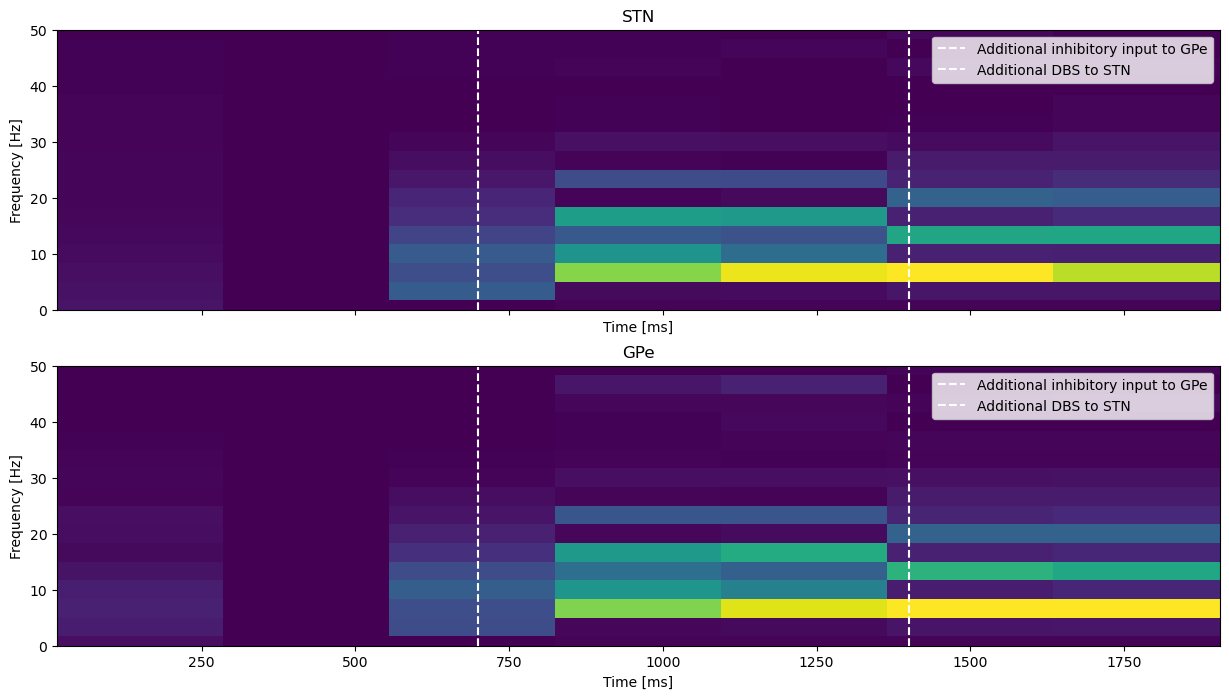

In [20]:
# plot spectrogram
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

f, t, Sxx = signal.spectrogram(fr_exc, fs=100, nperseg=30)
ax[0].pcolormesh(t * 1000, f, Sxx, cmap='viridis')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylim(0, 50)
ax[0].set_title('STN')

# plot spectrogram
f, t, Sxx = signal.spectrogram(fr_inh, fs=100, nperseg=30)
ax[1].pcolormesh(t * 1000, f, Sxx, cmap='viridis')

ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylim(0, 50)
ax[1].set_title('GPe')

# add lines to indicate the stimulation periods
ax[0].axvline(700, color='white', linestyle='--', label='Additional inhibitory input to GPe')
ax[0].axvline(1400, color='white', linestyle='--', label='Additional DBS to STN')
ax[1].axvline(700, color='white', linestyle='--', label='Additional inhibitory input to GPe')
ax[1].axvline(1400, color='white', linestyle='--', label='Additional DBS to STN')


ax[0].legend()
ax[1].legend()

# save the figure
fig.savefig('figs/spectrogram.png', dpi=300)

### Auto-correlation of the STN and GPe populations

In [23]:
counts_exc_no_input = fr_exc[:70]
counts_inh_no_input = fr_inh[:70]

counts_exc_inh_input = fr_exc[70:140]
counts_inh_inh_input = fr_inh[70:140]

counts_exc_dbs_input = fr_exc[140:]
counts_inh_dbs_input = fr_inh[140:]

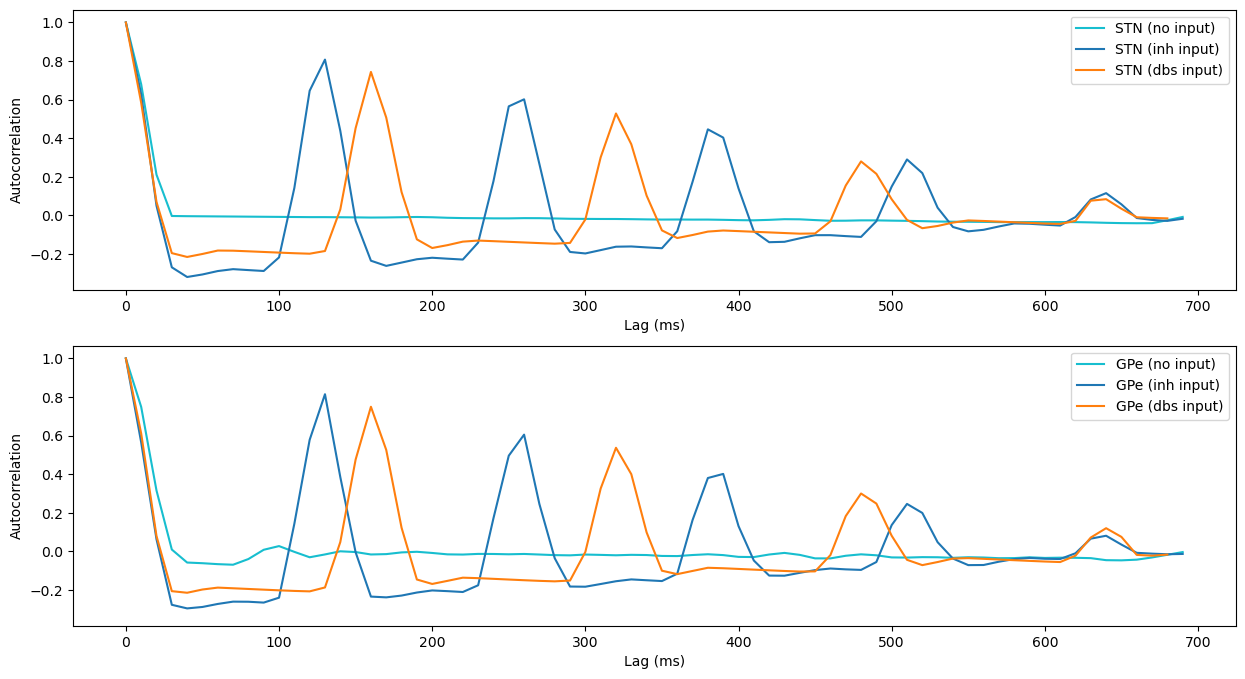

In [24]:
from neurodsp.aperiodic import compute_autocorr

timepoints_osc1, autocorrs_osc1 = compute_autocorr(counts_exc_no_input, max_lag=100)
timepoints_osc2, autocorrs_osc2 = compute_autocorr(counts_exc_inh_input, max_lag=100)
timepoints_osc3, autocorrs_osc3 = compute_autocorr(counts_exc_dbs_input, max_lag=100)

fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharey=True)

ax[0].plot(timepoints_osc1[:70] * 10, autocorrs_osc1, color='tab:cyan', label='STN (no input)')
ax[0].plot(timepoints_osc2[:70] * 10, autocorrs_osc2, color='tab:blue', label='STN (inh input)')
ax[0].plot(timepoints_osc3[:69] * 10, autocorrs_osc3, color='tab:orange', label='STN (dbs input)')

ax[0].set_xlabel('Lag (ms)')
ax[0].set_ylabel('Autocorrelation')

ax[0].legend()

timepoints_osc1, autocorrs_osc1 = compute_autocorr(counts_inh_no_input, max_lag=100)
timepoints_osc2, autocorrs_osc2 = compute_autocorr(counts_inh_inh_input, max_lag=100)
timepoints_osc3, autocorrs_osc3 = compute_autocorr(counts_inh_dbs_input, max_lag=100)

ax[1].plot(timepoints_osc1[:70] * 10, autocorrs_osc1, color='tab:cyan', label='GPe (no input)')
ax[1].plot(timepoints_osc2[:70] * 10, autocorrs_osc2, color='tab:blue', label='GPe (inh input)')
ax[1].plot(timepoints_osc3[:69] * 10, autocorrs_osc3, color='tab:orange', label='GPe (dbs input)')

ax[1].set_xlabel('Lag (ms)')
ax[1].set_ylabel('Autocorrelation')

ax[1].legend()

# save the figure
fig.savefig('figs/autocorrelation.png', dpi=300)

### How sensitive is the effect to changes in the DBS amplitude?

[-220 -219 -218 -217 -216 -215 -214 -213 -212 -211 -210 -209 -208 -207
 -206 -205 -204 -203 -202 -201 -200 -199 -198 -197 -196 -195 -194 -193
 -192 -191 -190 -189 -188 -187 -186 -185 -184 -183 -182 -181 -180 -179
 -178 -177 -176 -175 -174 -173 -172 -171 -170 -169 -168 -167 -166 -165
 -164 -163 -162 -161 -160 -159 -158 -157 -156 -155 -154 -153 -152 -151
 -150 -149 -148 -147 -146 -145 -144 -143 -142 -141 -140 -139 -138 -137
 -136 -135 -134 -133 -132 -131]

Jun 03 18:26:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jun 03 18:26:40 NodeManager::prepare_nodes [Info]: 
    Preparing 806 nodes for simulation.

Jun 03 18:26:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 806
    Simulation time (ms): 2100
    Number of OpenMP threads: 1
    Not using MPI

Jun 03 18:26:41 SimulationManager::run [Info]: 
    Simulation finished.

Jun 03 18:26:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0

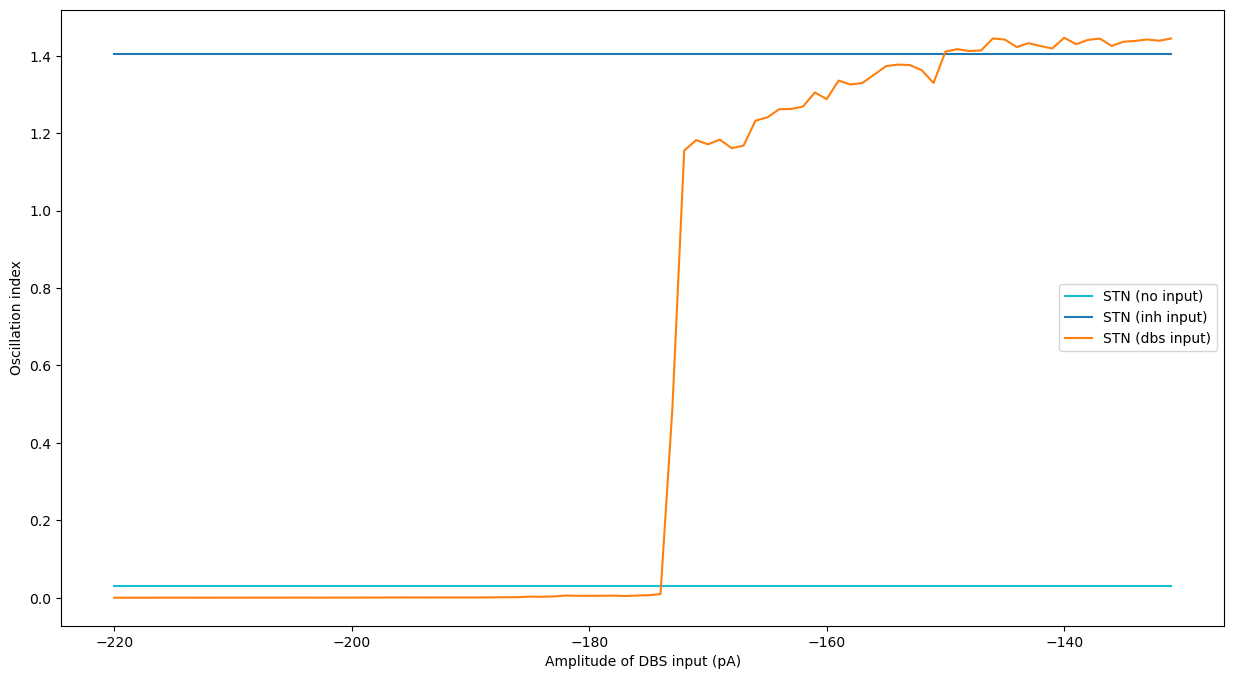

In [6]:
amplitudes = np.arange(-220, -130, 1)

print(amplitudes)

# fig, ax = plt.subplots(3, 3, figsize=(25, 18), sharex=True, sharey=True)

oi_osc1s, oi_osc2s, oi_osc3s = [], [], []

for amplitude in amplitudes:
    response = create_model(amplitude)
    vm1 = response["events"][0]
    sr1 = response["events"][1]
    sr2 = response["events"][2]

    spike_id_exc, spike_t_exc = sr1['senders'], sr1['times'] # from STN
    spike_id_inh, spike_t_inh = sr2['senders'], sr2['times'] # from GPe
    vm_id, vm_t = vm1['senders'], vm1['times']
    
    sr = 100
    bin_size = 1000/sr
    bins = np.arange(0,2100, bin_size)
    counts_exc, bins_exc = np.histogram(spike_t_exc, bins=bins)
    counts_inh, bins_inh = np.histogram(spike_t_inh, bins=bins)

    fr_exc = counts_exc / bin_size
    fr_inh = counts_inh / bin_size

    counts_exc_no_input = fr_exc[:70]
    counts_inh_no_input = fr_inh[:70]

    counts_exc_inh_input = fr_exc[70:140]
    counts_inh_inh_input = fr_inh[70:140]

    counts_exc_dbs_input = fr_exc[140:]
    counts_inh_dbs_input = fr_inh[140:]

    # compute power spectrum for each condition
    freqs_osc1, powers_osc1 = signal.welch(counts_exc_no_input, fs=100, nperseg=30)
    freqs_osc2, powers_osc2 = signal.welch(counts_exc_inh_input, fs=100, nperseg=30)
    freqs_osc3, powers_osc3 = signal.welch(counts_exc_dbs_input, fs=100, nperseg=30)

    # compute relative power for each condition in the beta band
    beta_osc1 = np.mean(powers_osc1[(freqs_osc1 > 13) & (freqs_osc1 < 30)])
    beta_osc2 = np.mean(powers_osc2[(freqs_osc2 > 13) & (freqs_osc2 < 30)])
    beta_osc3 = np.mean(powers_osc3[(freqs_osc3 > 13) & (freqs_osc3 < 30)])

    mean_power_osc1 = np.mean(powers_osc1)
    mean_power_osc2 = np.mean(powers_osc2)
    mean_power_osc3 = np.mean(powers_osc3)

    oi_osc1 = beta_osc1 / mean_power_osc1
    oi_osc2 = beta_osc2 / mean_power_osc2
    oi_osc3 = beta_osc3 / mean_power_osc3

    oi_osc1s.append(oi_osc1)
    oi_osc2s.append(oi_osc2)
    oi_osc3s.append(oi_osc3)

# plot the oi for each condition as a function of the amplitude of the input
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.plot(amplitudes, oi_osc1s, color='tab:cyan', label='STN (no input)')
ax.plot(amplitudes, oi_osc2s, color='tab:blue', label='STN (inh input)')
ax.plot(amplitudes, oi_osc3s, color='tab:orange', label='STN (dbs input)')
ax.set_xlabel('Amplitude of DBS input (pA)')
ax.set_ylabel('Oscillation index')
ax.legend()

# save the figure
fig.savefig('figs/oscillation_index.png', dpi=300)
